In [2]:
pip install pmdarima

     |████████████████████████████████| 2.1 MB 294 kB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
import math

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import train_test_split

from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, r2_score

import warnings
warnings.filterwarnings('ignore')

/home/alg_1132236009/.local/lib/python3.9/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
# Загрузил данные из файла
data = pd.read_csv("Walmart_store_sales.csv")
data.info()
data.head(150)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143 entries, 0 to 142
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          143 non-null    object 
 1   Weekly_Sales  143 non-null    float64
dtypes: float64(1), object(1)
memory usage: 2.4+ KB


,Date,Weekly_Sales
0,05-02-2010,1643690.90
1,12-02-2010,1641957.44
2,19-02-2010,1611968.17
3,26-02-2010,1409727.59
4,05-03-2010,1554806.68
...,...,...
138,28-09-2012,1437059.26
139,05-10-2012,1670785.97
140,12-10-2012,1573072.81
141,19-10-2012,1508068.77


In [3]:
# Поменял тип данных в колонке Date, задал эту колонку в качестве индекса
data['Date'] = pd.to_datetime(data['Date'], format='%d-%m-%Y')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143 entries, 0 to 142
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          143 non-null    datetime64[ns]
 1   Weekly_Sales  143 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 2.4 KB


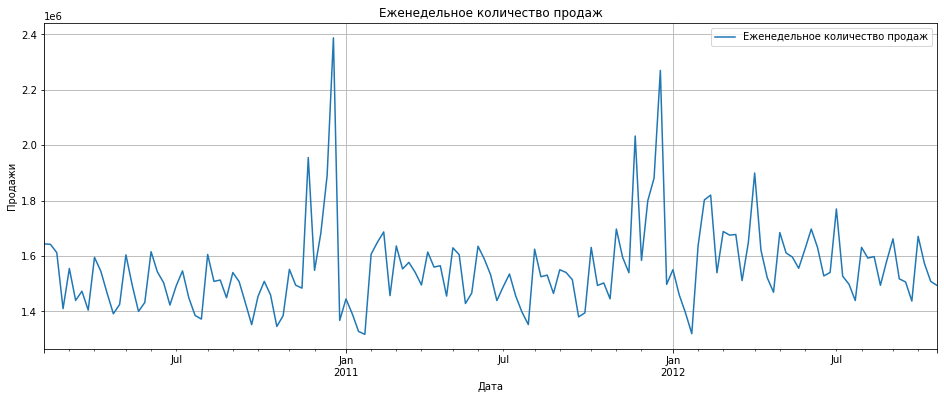

In [4]:
data.plot(x = 'Date', y = 'Weekly_Sales', figsize=(16,6), 
               grid=True, 
               xlabel='Дата',
               ylabel='Продажи',
               title='Еженедельное количество продаж')
plt.legend(['Еженедельное количество продаж'])
plt.show()

In [5]:
data.set_index('Date', inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 143 entries, 2010-02-05 to 2012-10-26
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Weekly_Sales  143 non-null    float64
dtypes: float64(1)
memory usage: 2.2 KB


In [6]:
adf_test = adfuller(data.values)

if adf_test[1] < 0.05:
    print('p-value = ', adf_test[1],
          '\nРяд стационарный')
else:
    print('p-value = ', adf_test[1],
          '\nРяд нестационарный')

p-value =  1.3877788330759535e-05 
Ряд стационарный


Тест на исходных данных показал, что ряд стационарный, а значит можно сразу определить d=0.

<Figure size 1152x432 with 0 Axes>

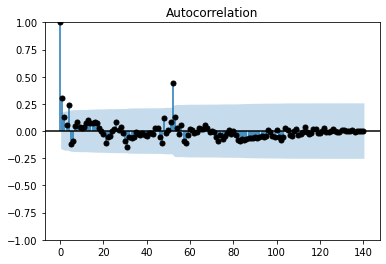

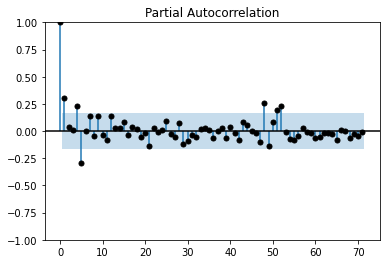

In [7]:
# Построил коррелограммы ACF и PACF для исходного ряда
plt.figure(figsize=(16, 6))
plot_acf(data.values, lags=140, color='black')
plot_pacf(data.values, lags=71,  color='black')
plt.show()

На обычном графике и на коррелограмме видна сезонность данных с периодом в примерно 52 недели

По коррелограмме определил параметры p = 5, q = 52 (тк arima не учитывает сезонность, параметр q = 52 дает лучшие показатели)

In [8]:
# Разобил ряд на обучающую и тестовую выборки в соотношении 93 на 7
x_train, x_test = train_test_split(data, 
                                   test_size=.07, 
                                   shuffle=False) 

In [9]:
# Создал и обучил модель ARIMA
model_arima = ARIMA(x_train.values, order=(5,0,52))
model_arima_fit = model_arima.fit()

In [10]:
# Задал начальную и конечную точку тестового прогноза
start = len(x_train)
end = len(x_train) + len(x_test) - 1

In [11]:
# Построил прогноз на тестовой выборке
predictions = model_arima_fit.predict(start, end)
predictions = pd.DataFrame({'pred': predictions}, index=x_test.index)

In [12]:
# Создадал функцию построения графика прогноза на тестовой выборке
def plot_prediction(df, test, pred):
    
    plt.figure(figsize=(16, 6))

    plt.plot(df, color = 'black')
    plt.plot(test, color = 'green')
    plt.plot(pred, color = 'red')
    
    plt.title('Обучающая выборка и прогноз')
    plt.legend(['Обучающая выборка', 'Тестовая выборка', 'Прогноз'])
    plt.ylabel('Количество вспышек')
    plt.xlabel('Дата')

    plt.grid()
    plt.show()

In [13]:
# Создадал функцию расчета метрик модели
df_model = pd.DataFrame({'model_name': [],'R2': [], 'MAE': []})
    
def model_char(test, pred, df, model_name):
    mae = mean_absolute_error(x_test, predictions)
    r2 = r2_score(x_test, predictions)
    df_model.loc[len(df_model.index )] = [model_name, r2, mae]
    return df_model

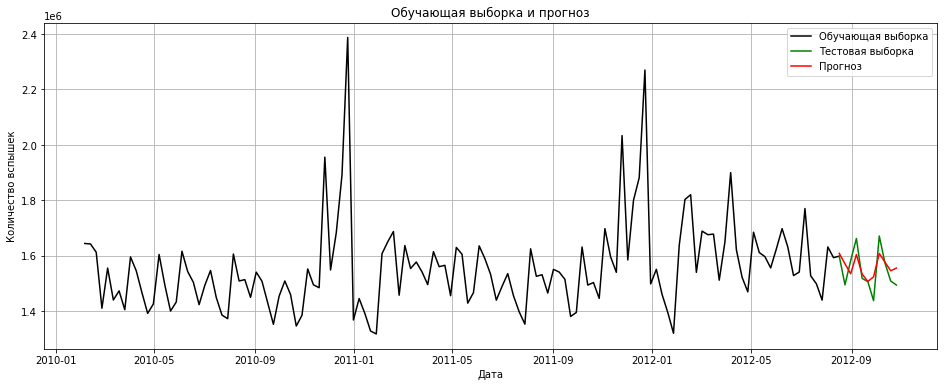

In [14]:
# Построил график с прогнозом 
plot_prediction(data[:len(x_train)+1], x_test, predictions)

In [15]:
model_char(x_test, predictions, df_model, 'ARIMA')

,model_name,R2,MAE
0,ARIMA,0.482732,41693.071233


Значения предсказываются не с самой лучшей точностью, но хотяб направление прогноза совпадает с действительностью

In [56]:
# Создал и обучил модель SARIMAX
model_sarimax = SARIMAX(x_train,
                order = (5, 0, 4),
                seasonal_order = (1, 1, 1, 52))

model_sarimax_fit = model_sarimax.fit()

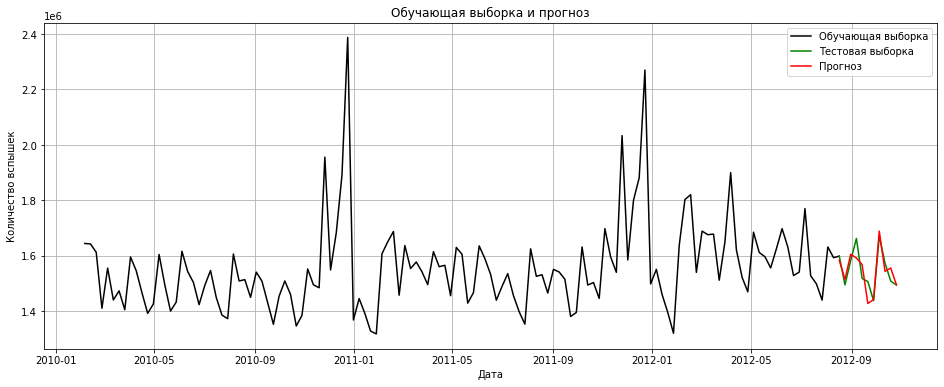

In [57]:
# Построил прогноз на тестовой выборке
predictions = model_sarimax_fit.predict(start, end)
plot_prediction(data[:len(x_train)+1], x_test, predictions)

In [58]:
# Рассчитал метрики модели
model_char(x_test, predictions, df_model, 'SARIMAX')

,model_name,R2,MAE
0,ARIMA,0.482732,41693.071233
1,SARIMAX,0.665849,32405.930810


Модель sarima учитывает сезонность, поэтому показывает более хорошие результаты

In [59]:
# Создадал модель auto_arima
auto_model = auto_arima(x_train.values, 
                        start_p=0, 
                        start_q=0, 
                        max_p=6, 
                        max_q=6,
                        d=0,
                        start_P=0, 
                        start_Q=0, 
                        max_P=5, 
                        max_D=2, 
                        max_Q=5, 
                        max_order=20,
                        m=52,
                        seasonal=True)
auto_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  132
Model:             SARIMAX(1, 0, 0)x(0, 0, [1, 2], 52)   Log Likelihood               -1741.940
Date:                                 Mon, 06 Oct 2025   AIC                           3493.880
Time:                                         19:37:26   BIC                           3508.294
Sample:                                              0   HQIC                          3499.737
                                                 - 132                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1.075e+06   1.58e+05      6.796      0.000    7.65e+05    1.39e+06
ar.L1          0.3107      0.088      3.538      0.000       0.139       0.483
ma.S.L52       0.6281      0.382      1.646      0.100      -0.120       1.376
ma.S.L104      0.2876      0.807      0.356      0.722      -1.294       1.869
sigma2      2.343e+10      0.161   1.45e+11      0.000    2.34e+10    2.34e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):               279.66
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               1.19   Skew:                             1.37
Prob(H) (two-sided):                  0.58   Kurtosis:                         9.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.61e+27. Standard errors may be unstable.
"""

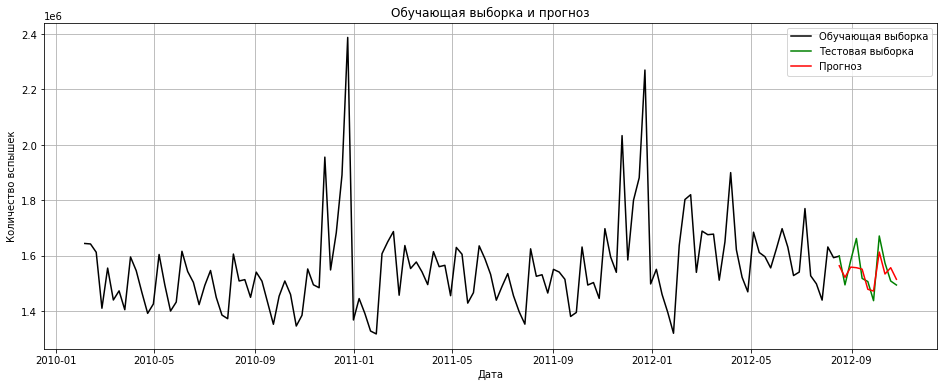

In [61]:
# Обучил модель на обучающей выборке и построил прогноз на тестовой
auto_model.fit(x_train)

predictions = auto_model.predict(n_periods=len(x_test))
predictions = pd.DataFrame({'pred': predictions}, index=x_test.index)
plot_prediction(data[:len(x_train)+1], x_test, predictions)

In [62]:
# рассчитаем метрики модели
model_char(x_test, predictions, df_model, 'auto_arima')

,model_name,R2,MAE
0,ARIMA,0.482732,41693.071233
1,SARIMAX,0.665849,32405.930810
2,auto_arima,0.552706,41285.686824


In [ ]:
# Определил оптимальные параметры  p, d, q, P, D, Q перебором

# Зададал диапазон значений для p, d, q, P, D, Q и m
p_values = range(1, 6)  
d_values = [0]         
q_values = range(1, 6)  
P_values = range(1, 6)  
D_values = range(0, 1)  
Q_values = range(1, 6)  
m_values = [51, 52, 53]         

# Создадал все возможные комбинации параметров SARIMAX
param_combinations = list(itertools.product(p_values, 
                                            d_values, 
                                            q_values, 
                                            P_values, 
                                            D_values, 
                                            Q_values, 
                                            m_values))

# Зададал нулевые начальные значения
best_r2 = 0  
best_params = None

# Выполнил поиск по сетке
for params in param_combinations:
    order = params[:3]
    seasonal_order = params[3:]
    
    try:
        model = SARIMAX(x_train.values, 
                        order=order, 
                        seasonal_order=seasonal_order)
        model_fit = model.fit(disp=False)
        predictions = model_fit.predict(start, end)
        r2 = r2_score(x_test, predictions)
        
        # проверим сходимость модели
        if not math.isinf(model_fit.zvalues.mean()):
            print(order, seasonal_order, r2)
        
            if r2 > best_r2:
                best_r2 = r2
                best_params = params
                
        else:
            print(order, seasonal_order, 'нет сходимости')

    except:
        continue

print("Лучшие параметры:", best_params)
print("Лучший коэффициент R2:", best_r2)